In [1]:
import pylab
import pymoc
import xidplus
import numpy as np
%matplotlib inline
from astropy.table import Table
from astropy.io import fits
from astropy import wcs
import seaborn as sns

/cm/shared/apps/python/intel/intelpython3/3.5.3/envs/jupyterhub/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


This notebook uses all the raw data from the XID+MIPS catalogue, maps, PSF and relevant MOCs to create XID+ prior object and relevant tiling scheme

## Read in MOCs
The selection functions required are the main MOC associated with the masterlist. As the prior for XID+ is based on IRAC detected sources coming from two different surveys at different depths (SPUDS and SWIRE) I will split the XID+ run into two different runs. Here we use the SWIRE depth.

In [2]:
Sel_func=pymoc.MOC()
Sel_func.read('../../dmu4/dmu4_sm_XMM-LSS/data/holes_XMM-LSS_irac1_O16_20180420_MOC.fits')
SWIRE_MOC=pymoc.MOC()
SWIRE_MOC.read('../../dmu0/dmu0_DataFusion-Spitzer/data/Sub_wp4_xmm-lss_mips24_map_v1-1-_MOCmips_mosaic_MOC.fits')
Final=Sel_func.intersection(SWIRE_MOC)

## Read in XID+MIPS catalogue

In [3]:
XID_MIPS=Table.read('../dmu26_XID+MIPS_XMM-LSS/data/dmu26_XID+MIPS_XMM-LSS_SWIREnSPUDS_concat_20190106.fits')

In [4]:
XID_MIPS[0:10]

help_id,RA,Dec,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24
,degrees,degrees,muJy,muJy,muJy,MJy / sr,MJy / sr,,,,
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,bool
HELP_J021846.087-062301.346,34.692030947564795,-6.383707158297614,30.09487,46.226128,14.67685,-0.0009270066,4.858147e-06,nan,1142.0,0.0,False
HELP_J021843.070-062345.559,34.6794586722776,-6.39598871477323,4170.4424,4190.5127,4150.0,-0.0009270066,4.858147e-06,nan,2000.0,0.373,False
HELP_J021852.610-062138.457,34.7192093322776,-6.36068236477323,327.6509,346.8575,307.92105,-0.0046012965,4.779417e-06,nan,1248.0,0.0,False
HELP_J021854.601-062151.326,34.7275025122776,-6.36425716477323,65.46506,83.40683,47.538906,-0.0046012965,4.779417e-06,nan,1179.0,0.398,False
HELP_J021851.714-062215.569,34.7154747122776,-6.3709913347732305,3.1386747,7.2766647,0.9495287,-0.0046012965,4.779417e-06,nan,1711.0,0.0,True
HELP_J021911.572-062135.966,34.7982186822776,-6.359990434773231,554.56165,571.6919,537.1004,-0.012682672,4.8390184e-06,nan,555.0,0.0,False
HELP_J021917.826-062026.091,34.8242763422776,-6.34058070477323,963.8944,982.96875,944.89764,-0.005463596,4.9658024e-06,nan,893.0,0.011,False
HELP_J021923.350-061946.651,34.8472902722776,-6.32962525477323,2255.2812,2275.3945,2235.6658,0.0036527414,4.8568736e-06,nan,2000.0,0.0,False


4.987116
630


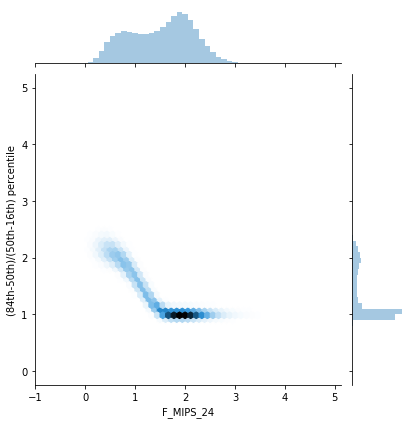

In [5]:
skew=(XID_MIPS['FErr_MIPS_24_u']-XID_MIPS['F_MIPS_24'])/(XID_MIPS['F_MIPS_24']-XID_MIPS['FErr_MIPS_24_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
use = skew < 5 
n_use=skew>5
g=sns.jointplot(x=np.log10(XID_MIPS['F_MIPS_24'][use]),y=skew[use] ,kind='hex')
print(np.max(skew[use]))
print(len(skew[n_use]))

The uncertianties become Gaussian by $\sim 20 \mathrm{\mu Jy}$

In [6]:
good=XID_MIPS['F_MIPS_24']>20

In [7]:
good.sum()

287595

## Read in Maps

In [8]:
#im100fits='../../dmu18/dmu18_XMM-LSS/data/input_data/XMM-LSS_PACS100_20160728_img_wgls.fits'#PACS 100 map
#nim100fits='../../dmu18/dmu18_XMM-LSS/data/input_data/XMM-LSS_PACS100_20160728_img_noise.fits'#PACS 100 noise map
#im160fits='../../dmu18/dmu18_XMM-LSS/data/input_data/XMM-LSS_PACS160_20160728_img_wgls.fits'#PACS 160 map
#nim160fits='../../dmu18/dmu18_XMM-LSS/data/input_data/XMM-LSS_PACS160_20160728_img_noise.fits'#PACS 100 noise map

im100fits='../../dmu18/dmu18_XMM-LSS/data/input_data/XMM-LSS_PACS100_v0.9.fits'#PACS 100 map
im160fits='../../dmu18/dmu18_XMM-LSS/data/input_data/XMM-LSS_PACS160_v0.9.fits'#PACS 160 map

#output folder
output_folder='./'

In [9]:
hdulist = fits.open(im100fits)
hdulist[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
CREATOR = 'Herschel Extragalactic Legacy Project'                               
TIMESYS = 'UTC     '           / All dates are in UTC time                      
DATE    = '2018-02-06T12:46:23' / Date of file creation                         
VERSION = '0.9     '           / HELP product version                           
TELESCOP= 'Herschel'           / Name of the telescope                          
INSTRUME= 'PACS    '           / Name of the instrument                         
FILTER  = 'PACS-100'           / Name of the filter                             
FIELD   = 'XMM-LSS '           / Name of the HELP field                         
OBSID000=           13422130

In [10]:
from astropy.io import fits
from astropy import wcs

#-----100-------------
hdulist = fits.open(im100fits)
im100phdu=hdulist['PRIMARY'].header
im100hdu=hdulist['IMAGE'].header
im100=hdulist['IMAGE'].data
w_100 = wcs.WCS(hdulist['IMAGE'].header)
pixsize100=3600.0*np.abs(hdulist['IMAGE'].header['CDELT1']) #pixel size (in arcseconds)
nim100=hdulist['ERROR'].data

hdulist.close()

#-----160-------------
hdulist = fits.open(im160fits)
im160phdu=hdulist['PRIMARY'].header
im160hdu=hdulist['IMAGE'].header
im160=hdulist['IMAGE'].data
w_160 = wcs.WCS(hdulist['IMAGE'].header)
pixsize160=3600.0*np.abs(hdulist['IMAGE'].header['CDELT1']) #pixel size (in arcseconds)
nim160=hdulist['ERROR'].data

hdulist.close()

## Read in PSF

In [11]:
pacs100_psf=fits.open('../../dmu18/dmu18_XMM-LSS/dmu18_PACS_100_PSF_XMM-LSS_20190125_sr.fits')
pacs160_psf=fits.open('../../dmu18/dmu18_XMM-LSS/dmu18_PACS_160_PSF_XMM-LSS_20190125_sr.fits')

pacs100_psf['IMAGE'].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  301 /                                                
NAXIS2  =                  301 /                                                
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
IMG_TYPE= 'wgls    '                                                            
CTYPE1  = 'RA---TAN'           /                                                
CTYPE2  = 'DEC--TAN'           /                                                
CRPIX1  =       -4.46484300000 /                                                
CRPIX2  =       -3.85839900000 /                                                
CRVAL1  =        0.000000000

In [12]:
centre100=np.long((pacs100_psf[1].header['NAXIS1']-1)/2)
radius100=15
centre160=np.long((pacs160_psf[1].header['NAXIS1']-1)/2)
radius160=15

pind100=np.arange(0,radius100+1+radius100,1)*3600*np.abs(pacs100_psf[1].header['CDELT1'])/pixsize100 #get 100 scale in terms of pixel scale of map
pind160=np.arange(0,radius160+1+radius160,1)*3600*np.abs(pacs160_psf[1].header['CDELT1'])/pixsize160 #get 160 scale in terms of pixel scale of map



In [13]:
print(pind100)

[ 0.          0.33333333  0.66666667  1.          1.33333333  1.66666667
  2.          2.33333333  2.66666667  3.          3.33333333  3.66666667
  4.          4.33333333  4.66666667  5.          5.33333333  5.66666667
  6.          6.33333333  6.66666667  7.          7.33333333  7.66666667
  8.          8.33333333  8.66666667  9.          9.33333333  9.66666667
 10.        ]


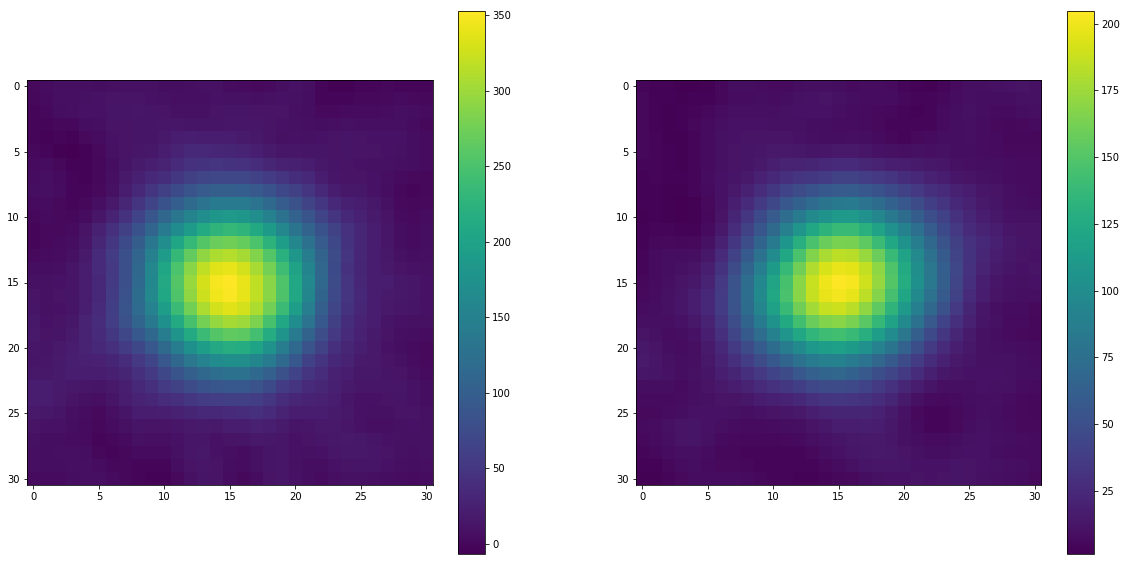

In [14]:
import pylab as plt
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(pacs100_psf[1].data[centre100-radius100:centre100+radius100+1,centre100-radius100:centre100+radius100+1])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(pacs160_psf[1].data[centre160-radius160:centre160+radius160+1,centre160-radius160:centre160+radius160+1])
plt.colorbar()


## Set XID+ prior class

In [15]:
#---prior100--------
prior100=xidplus.prior(im100,nim100,im100phdu,im100hdu, moc=Final)#Initialise with map, uncertianty map, wcs info and primary header
prior100.prior_cat(XID_MIPS['RA'][good],XID_MIPS['Dec'][good],'dmu26_XID+MIPS_XMM-LSS_SWIREnSPUDS_concat_20190106.fits',ID=XID_MIPS['help_id'][good])#Set input catalogue
prior100.prior_bkg(0.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)

#---prior160--------
prior160=xidplus.prior(im160,nim160,im160phdu,im160hdu, moc=Final)
prior160.prior_cat(XID_MIPS['RA'][good],XID_MIPS['Dec'][good],'dmu26_XID+MIPS_XMM-LSS_SWIREnSPUDS_concat_20190106.fits',ID=XID_MIPS['help_id'][good])
prior160.prior_bkg(0.0,5)


In [16]:
# Divide by 1000 so that units are mJy
prior100.set_prf(pacs100_psf[1].data[centre100-radius100:centre100+radius100+1,centre100-radius100:centre100+radius100+1]/1000.0,
                pind100,pind100)
prior160.set_prf(pacs160_psf[1].data[centre160-radius160:centre160+radius160+1,centre160-radius160:centre160+radius160+1]/1000.0,
                pind160,pind160)

In [17]:
import pickle
#from moc, get healpix pixels at a given order
from xidplus import moc_routines
order=11
tiles=moc_routines.get_HEALPix_pixels(order,prior100.sra,prior100.sdec,unique=True)
order_large=6
tiles_large=moc_routines.get_HEALPix_pixels(order_large,prior100.sra,prior100.sdec,unique=True)
print('----- There are '+str(len(tiles))+' tiles required for input catalogue and '+str(len(tiles_large))+' large tiles')
output_folder='./data/SWIRE/'
outfile=output_folder+'Master_prior_SWIRE.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'priors':[prior100,prior160],'tiles':tiles,'order':order,'version':xidplus.io.git_version()},f)
outfile=output_folder+'Tiles_SWIRE.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'tiles':tiles,'order':order,'tiles_large':tiles_large,'order_large':order_large,'version':xidplus.io.git_version()},f)
raise SystemExit()

----- There are 9883 tiles required for input catalogue and 21 large tiles


SystemExit: 